In [52]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [31]:
df = pd.read_csv("cleaned_US_Accidents.csv", index_col=0)

df = df.drop('State', axis=1)
df = df.drop('Weather_Condition_Score', axis=1)

In [37]:
clean_df = pd.get_dummies(df, columns=["Wind_Direction"])

In [38]:
high_risk = clean_df[clean_df['Severity'] >= 3]
#high_risk = clean_df[clean_df['Severity'] == 4]

In [39]:
#Look at the most severe plots

X = high_risk.drop('Severity', axis=1)
y = high_risk['Severity']

In [41]:
#split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#train the model
rfc = RandomForestClassifier(n_estimators=100, random_state=42, oob_score=True)
rfc.fit(X_train, y_train)

print("OOB score:", rfc.oob_score_)

OOB score: 0.8573976623729455


In [43]:
#get the feature importances
importance = rfc.feature_importances_
feat_importance = pd.Series(importance, index=X.columns).sort_values(ascending=False)

print("Feature Importance:")
print(feat_importance)

Feature Importance:
Pressure(in)               0.238269
Humidity(%)                0.189457
Temperature(F)             0.161655
Wind_Chill(F)              0.100990
Wind_Speed(mph)            0.098543
Visibility(mi)             0.040252
Precipitation(in)          0.013784
Junction                   0.013025
Weather_Condition          0.010551
Traffic_Signal             0.007453
Stop                       0.007187
Wind_Direction_SSW         0.006180
Wind_Direction_SW          0.006128
Wind_Direction_WSW         0.005953
Wind_Direction_SSE         0.005839
Wind_Direction_NNW         0.005724
Wind_Direction_WNW         0.005693
Wind_Direction_NW          0.005600
Wind_Direction_NE          0.005146
Crossing                   0.005145
Wind_Direction_SE          0.005097
Wind_Direction_S           0.005018
Wind_Direction_NNE         0.004940
Wind_Direction_ESE         0.004873
Wind_Direction_ENE         0.004789
Wind_Direction_W           0.004486
Wind_Direction_N           0.004448
Wind_Dir

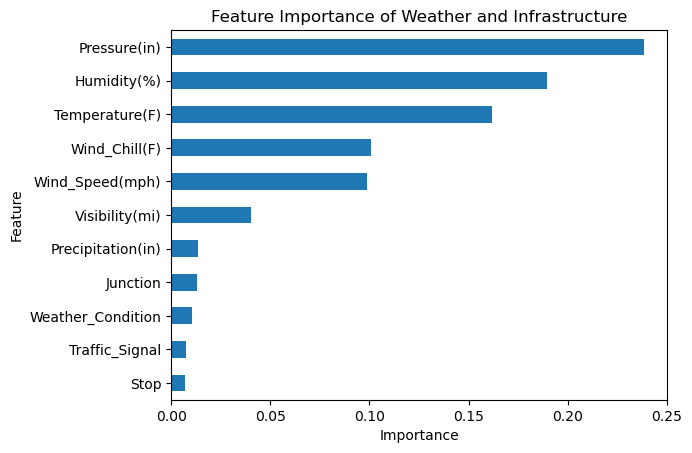

In [50]:
k = len(feat_importance) // 4
indices = np.argsort(feat_importance)[-k:]

# k = len(feat_importance)
# indices = np.argsort(feat_importance)
new_feat_import = feat_importance.iloc[indices]

new_feat_import.plot(kind='barh')
plt.title("Feature Importance of Weather and Infrastructure")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [51]:
print("Train accuracy:", rfc.score(X_train, y_train))
print("Test accuracy:", rfc.score(X_test, y_test))

Train accuracy: 0.9951215766875151
Test accuracy: 0.86181785967399


In [54]:
#finding if it's biased or not
# Take a 10% or 5% sample of X_test
X_test_small = X_test.sample(frac=0.30, random_state=42)
y_test_small = y_test.loc[X_test_small.index]

r = permutation_importance(rfc, X_test_small, y_test_small, n_repeats=10, random_state=42)

top = 0
featu_top = []
lib = {}
for name, imp in zip(X_test.columns, r.importances_mean):
    print(name, imp)
    lib[name] = imp
    if imp > top:
        top = imp
        featu_top = name

Temperature(F) 0.01227852586817858
Wind_Chill(F) 0.0092074179069218
Humidity(%) 0.012585636664304267
Pressure(in) 0.018101819040869337
Visibility(mi) 0.0055220883534136565
Wind_Speed(mph) 0.009053862508858968
Precipitation(in) 0.0018544767304512044
Weather_Condition 0.0026695015355539644
Amenity 0.00032482872667137784
Bump 0.0
Crossing 0.001417434443656973
Give_Way 0.00014174344436569398
Junction 0.0016477675407512327
No_Exit -1.1811953697149491e-05
Railway 0.00017127332860854548
Roundabout 0.0
Station 5.905976848570304e-05
Stop 0.0018781006378454812
Traffic_Calming 5.9059768485747455e-05
Traffic_Signal 0.0012225372076541175
Turning_Loop 0.0
Wind_Direction_0 -4.134183793997881e-05
Wind_Direction_CALM 0.0011457595086227013
Wind_Direction_Calm 0.00012402551381999194
Wind_Direction_E 0.00042523033309707083
Wind_Direction_ENE 0.0002893928655799405
Wind_Direction_ESE 0.00048429010158278495
Wind_Direction_East 0.00038979447200565565
Wind_Direction_N 0.000159461374911396
Wind_Direction_NE 0.0

True


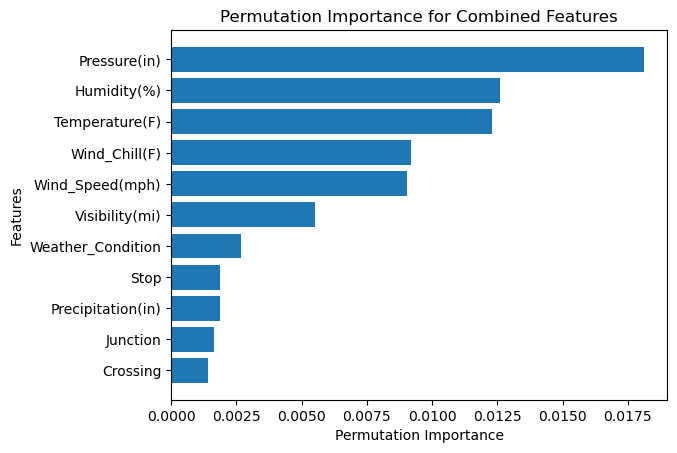

In [58]:
lib_nonneg = {k: max(0, v) for k, v in lib.items()}
sorted_items = sorted(lib_nonneg.items(), key=lambda x: x[1])
features, importances = zip(*sorted_items)

print(len(features) == len(importances))
k = len(features) // 4
features = features[-k:]
importances = importances[-k:]


plt.barh(features, importances)
plt.title("Permutation Importance for Combined Features")
plt.xlabel("Permutation Importance")
plt.ylabel("Features")
plt.show()